<a href="https://colab.research.google.com/github/robinjmf/Matrix-decomposition/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project : Cell image segmentation projects**


---



**Team** (Alphabetical order)**:** Arvin Jafari, Delnavaz Fotouhi, Reza Ghahremani

**University:** Università degli Studi di Milano

** This course is provided by 4EU+ alliance of European universities, Heidelberg University will coordinate a joint course on Applications of Deep Learning in Life Sciences (DeepLife) involving the universities of Paris-Sorbonne, Warsaw, Prague, Milano and Heidelberg.

**Reference:** https://deeplife4eu.github.io/


---



Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide contains both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)

### Project aim

The aim of the project is to download the cell images (preferably from the “2018 Data Science Bowl” competition) and assess the performance of an UNet or any other Deep model for cell segmentation.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


## **Step 1: Data Preparation**

**1.1. Install and Upgrade Kaggle Package**

The Kaggle Python package was installed and upgraded to ensure we have the latest version with all necessary functionalities.

In [1]:
!pip install --upgrade kaggle

**1.2. Verify and Create Kaggle Directory**

We verified if the ~/.kaggle directory exists. If not, the directory was created to store the Kaggle API credentials.

In [2]:
import os

# Verify ~/.kaggle directory exists
kaggle_dir = os.path.expanduser('~/.kaggle')
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
    print("Directory created: ~/.kaggle")
else:
    print("Directory already exists: ~/.kaggle")

Directory created: ~/.kaggle


**1.3. Copy Kaggle JSON to Kaggle Directory**

The kaggle.json file, which contains the API credentials, was copied to the ~/.kaggle directory. Permissions were set to ensure the file is secure.

In [3]:
import shutil

kaggle_json_path = 'kaggle.json'
target_path = os.path.join(kaggle_dir, 'kaggle.json')

if os.path.exists(kaggle_json_path):
    shutil.copy(kaggle_json_path, target_path)
    os.chmod(target_path, 0o600)
    print("kaggle.json has been copied to ~/.kaggle and permissions set.")
else:
    print("kaggle.json not found in the current directory.")

kaggle.json not found in the current directory.


**1.4. Set Environment Variables for Kaggle API**

Environment variables for the Kaggle username and key were set to enable authentication for API requests.

**reference:** https://www.kaggle.com/docs/api

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = input()
os.environ['KAGGLE_KEY'] = input()

arvinjmf
08908e6b7e12d90cd270e1aa2bfc58c9


**1.5. Download Dataset from Kaggle and Extract Dataset**

The dataset for the Data Science Bowl 2018 competition was downloaded using the Kaggle API. The downloaded zip file was extracted into a directory named data.

In [40]:
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:09<00:00, 70.4MB/s]
100% 358M/358M [00:09<00:00, 39.9MB/s]


In [41]:
!unzip data-science-bowl-2018.zip -d data

Archive:  data-science-bowl-2018.zip
  inflating: data/stage1_sample_submission.csv.zip  
  inflating: data/stage1_solution.csv.zip  
  inflating: data/stage1_test.zip    
  inflating: data/stage1_train.zip   
  inflating: data/stage1_train_labels.csv.zip  
  inflating: data/stage2_sample_submission_final.csv.zip  
  inflating: data/stage2_test_final.zip  


**1.6. Navigate to Data Directory and Extract All Files and List Directory Contents**

Changed the current working directory to data and extracted all zip files within it. The original zip files were then deleted. Finally, we listed the contents of the data directory to confirm the successful extraction of the dataset files.

In [7]:
cd data

/content/data


In [42]:
!for file in *.zip; do unzip -q "$file" -d "${file%%.*}" && rm "$file"; done

In [43]:
ls

data/                      stage1_solution/  stage1_train_labels/             test/
data-science-bowl-2018/    stage1_test/      stage2_sample_submission_final/  toy_data/
stage1_sample_submission/  stage1_train/     stage2_test_final/               train/


## **Step 2: Data Preprocessing and Augmenation**

**2.1. Stretch Contrast Function**

This function stretches the contrast of an image to utilize the full range of pixel values (0 to 255).

In [44]:
def stretch_contrast(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = (image - min_val) * (255.0 / (max_val - min_val))
    return stretched_image.astype(np.uint8)

**2.2. Load Data Function**

The load_data function is designed to load images and their corresponding masks from a given base directory, apply contrast stretching to the images, and organize the data into lists.

In [45]:
# def load_data(base_path):
#     images = []
#     masks = []
#     sample_names = []

#     sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

#     for sample_folder in sample_folders:
#         sample_name = os.path.basename(sample_folder)
#         image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
#         masks_path = os.path.join(sample_folder, 'masks')

#         image = Image.open(image_path)
#         image = np.array(image)
#         stretched_image = stretch_contrast(image)
#         images.append(stretched_image)
#         sample_names.append(sample_name)

#         mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
#         sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
#         masks.append(sample_masks)

#     return images, masks, sample_names

In [46]:
import os
import shutil
import random

# Define the source directory
source_dir = "/content/data/stage1_train"

# Define the destination directory
dest_dir = "/content/data/toy_data"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Get a list of all folders in the source directory
folders = os.listdir(source_dir)

# Randomly select 50 folders
selected_folders = random.sample(folders, 50)

# Copy selected folders to the destination directory
for folder in selected_folders:
    src = os.path.join(source_dir, folder)
    dst = os.path.join(dest_dir, folder)
    shutil.copytree(src, dst)

print("Selected folders have been copied to the 'toy_data' folder.")

FileExistsError: [Errno 17] File exists: '/content/data/toy_data/ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716'

In [47]:
def load_data(base_path):
    images = []
    masks = []
    sample_names = []
    sample_folders = []

    # Get all sample folders
    sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_folder in sample_folders:
        sample_name = os.path.basename(sample_folder)
        image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
        masks_path = os.path.join(sample_folder, 'masks')

        # Load the image and stretch contrast
        image = Image.open(image_path)
        image = np.array(image)
        stretched_image = stretch_contrast(image)
        images.append(stretched_image)
        sample_names.append(sample_name)

        # Load all masks for this sample
        mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
        sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
        masks.append(sample_masks)

    return images, masks, sample_names, sample_folders

In [48]:
# import os
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# # Example usage:
# base_path = '/content/data/toy_data'
# images, masks, sample_names = load_data(base_path)

# # Access the first sample
# first_sample_index = 0
# first_sample_name = sample_names[first_sample_index]
# first_sample_image = images[first_sample_index]
# first_sample_masks = masks[first_sample_index]

# # Print the sample name and display the image
# print(f'First sample name: {first_sample_name}')
# plt.figure()
# plt.imshow(first_sample_image)
# plt.title(f'Image: {first_sample_name}')
# plt.axis('off')
# plt.show()

# # Display the masks
# for i, mask in enumerate(first_sample_masks):
#     plt.figure()
#     plt.imshow(mask, cmap='gray')
#     plt.title(f'Mask {i + 1} for sample {first_sample_name}')
#     plt.axis('off')
#     plt.show()

# # Merge and display the masks
# merged_mask = merge_masks(first_sample_masks)

# plt.figure()
# plt.imshow(merged_mask, cmap='gray')
# plt.title(f'Merged Mask for sample {first_sample_name}')
# plt.axis('off')
# plt.show()

**2.3. Merge Masks Function**

This function merges multiple masks by adding the values of corresponding pixels.

In [49]:
def merge_masks(masks):
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        mask_uint8 = mask.astype(np.uint8)
        merged_mask += mask_uint8
    return merged_mask

**2.4. Mask Merging**

The masks are merged to create a single composite mask for each sample, which is then saved for further analysis.

In [50]:
import numpy as np
from PIL import Image

In [51]:
# This function saves the merged mask as an image file in the 'merged_masks' folder within the sample folder.
def save_merged_mask(merged_mask, sample_folder):
    merged_masks_dir = os.path.join(sample_folder, 'merged_masks')
    os.makedirs(merged_masks_dir, exist_ok=True)
    sample_name = os.path.basename(sample_folder)
    output_path = os.path.join(merged_masks_dir, f"{sample_name}_merged_mask.png")
    merged_mask_image = Image.fromarray(merged_mask)
    merged_mask_image.save(output_path)
    print(f"Merged mask saved at: {output_path}")

In [52]:
# This function loads the data, merges the masks for each sample, and saves the merged masks in the corresponding folders.
def process_and_save_merged_masks(base_path):
    images, masks, sample_names, sample_folders = load_data(base_path)
    for sample_name, sample_masks, sample_folder in zip(sample_names, masks, sample_folders):
        merged_mask = merge_masks(sample_masks)
        save_merged_mask(merged_mask, sample_folder)

In [53]:
base_path = '/content/data/toy_data'
process_and_save_merged_masks(base_path)

Merged mask saved at: /content/data/toy_data/7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072/merged_masks/7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072_merged_mask.png
Merged mask saved at: /content/data/toy_data/76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450/merged_masks/76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450_merged_mask.png
Merged mask saved at: /content/data/toy_data/d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a/merged_masks/d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a_merged_mask.png
Merged mask saved at: /content/data/toy_data/866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855/merged_masks/866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855_merged_mask.png
Merged mask saved at: /content/data/toy_data/97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034/merged_masks/97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1

In [54]:
base_path = '/content/data/stage1_train'
process_and_save_merged_masks(base_path)

Merged mask saved at: /content/data/stage1_train/a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c/merged_masks/a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c_merged_mask.png
Merged mask saved at: /content/data/stage1_train/72e8c49dea44787114fd191f9e97e260f961c6e7ae4715bc95cc91db8d91a4e3/merged_masks/72e8c49dea44787114fd191f9e97e260f961c6e7ae4715bc95cc91db8d91a4e3_merged_mask.png
Merged mask saved at: /content/data/stage1_train/cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e/merged_masks/cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e_merged_mask.png
Merged mask saved at: /content/data/stage1_train/0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f/merged_masks/0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f_merged_mask.png
Merged mask saved at: /content/data/stage1_train/da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8/merged_masks/da31f2aa8601afec5c45180a2c448cb9c4a8ec7b3

**2.4. Data organization**

In [55]:
import os
import shutil
from PIL import Image

def extract_images(stage1_path, destination_path, content_type='images'):
    """
    Extract all images or merged masks from the stage1_train or stage1_test folder and save them into the specified destination folder.

    Args:
    - stage1_path (str): Path to the stage1_train or stage1_test folder containing sample folders.
    - destination_path (str): Path to the destination folder where images or masks will be saved.
    - content_type (str): Type of content to extract ('images' or 'merged_masks').
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Determine the subfolder to look for based on content type
    subfolder_name = 'images' if content_type == 'images' else 'merged_masks'

    # Iterate over all sample folders in the stage1 directory
    for sample_folder in os.listdir(stage1_path):
        sample_folder_path = os.path.join(stage1_path, sample_folder, subfolder_name)

        # Check if the sample folder contains the specified subfolder
        if os.path.isdir(sample_folder_path):
            for file in os.listdir(sample_folder_path):
                if file.endswith('.png'):
                    # Construct the full path to the file
                    file_path = os.path.join(sample_folder_path, file)

                    # Save the file to the destination directory
                    destination_file_path = os.path.join(destination_path, f"{sample_folder}_{file}")
                    shutil.copy(file_path, destination_file_path)
                    print(f"Copied: {file_path} to {destination_file_path}")

In [56]:
def main(destination_path):
    if 'train/images' in destination_path:
        stage1_path = '/content/data/toy_data'
        content_type = 'images'
    elif 'train/masks' in destination_path:
        stage1_path = '/content/data/toy_data'
        content_type = 'masks'
    elif 'test/images' in destination_path:
        stage1_path = '/content/data/toy_data'
        content_type = 'images'
    else:
        print("Invalid destination path")
        return

    extract_images(stage1_path, destination_path, content_type)

In [57]:
destination_path = '/content/data/train/images'
main(destination_path)

destination_path = '/content/data/train/masks'
main(destination_path)

destination_path = '/content/data/test/images'
main(destination_path)

Copied: /content/data/toy_data/7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072/images/7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072.png to /content/data/train/images/7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072_7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072.png
Copied: /content/data/toy_data/76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450/images/76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450.png to /content/data/train/images/76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450_76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450.png
Copied: /content/data/toy_data/d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a/images/d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a.png to /content/data/train/images/d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a_d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f536

In [58]:
!pip install opencv-python-headless matplotlib scikit-image tqdm tensorflow tensorflow-datasets


In [59]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [60]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [61]:
images_path = "/content/data/train/images"
masks_path = "/content/data/train/masks"

In [62]:
OUTPUT_CHANNELS = 2
classes = {'nothing':0, 'nucleon':1}

In [63]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x

def preprocessing(img):
    image = np.array(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.zeros_like(image)
    image[:,:,0] = gray
    image[:,:,1] = gray
    image[:,:,2] = gray
    image = standardize(image)
    return image

In [64]:
#Capture training image info as a list
images_paths = []
masks_paths = []

for imgname in os.listdir(images_path):
  images_paths.append(os.path.join(images_path,imgname))

for imgname in os.listdir(masks_path):
  masks_paths.append(os.path.join(masks_path,imgname))

In [65]:
images_paths.sort()
masks_paths.sort()

In [66]:

# Resize images
SIZE_X = 256
SIZE_Y = 256

# Capture training image info as a list
train_images = []
train_masks = []

for imgpath in tqdm.tqdm(images_paths):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = preprocessing(img)
    train_images.append(img)

for maskpath in tqdm.tqdm(masks_paths):
    mask0 = cv2.imread(maskpath, 0)
    mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
    # Assuming that 'class1' is the class you want to keep and 'bg' is the background class
    mask1[mask1 != classes['nothing']] = classes['nucleon']  # Set all classes except 'class1' to background
    train_masks.append(mask1)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.10, shuffle=True, random_state=1)
print("Class values: ", np.unique(y_train))

100%|██████████| 55/55 [00:00<00:00, 668.74it/s]


Class values:  [0 1]


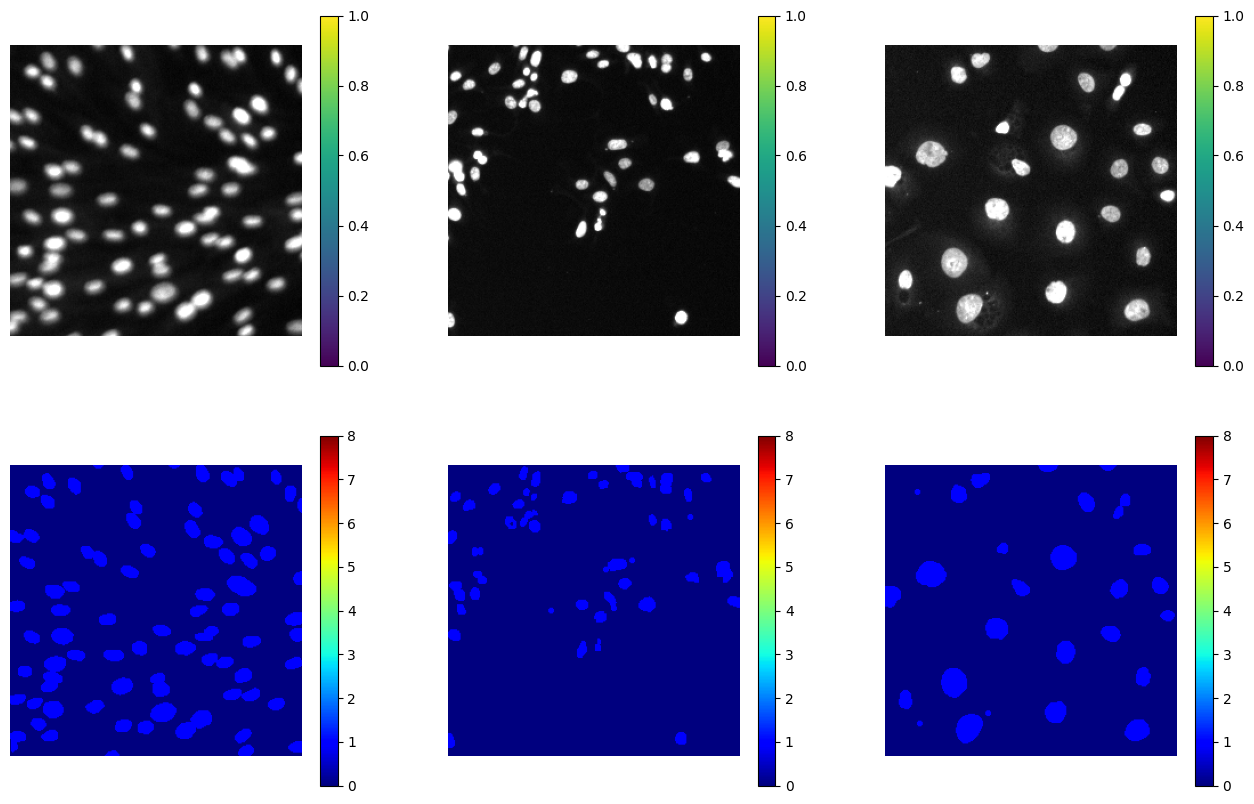

In [67]:
NORM = mpl.colors.Normalize(vmin=0, vmax=8)

plt.figure(figsize=(16,10))
for i in range(1,4):
    plt.subplot(2,3,i)
    img = train_images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')

for i in range(4,7):
    plt.subplot(2,3,i)
    img = np.squeeze(train_masks[i-3])
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [68]:
def unet_model(output_channels):
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    base_model = MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(OUTPUT_CHANNELS, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [77]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(epoch, dataset=None, num=5):
  if dataset:

    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        plt.figure(figsize=(15, 10))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(image[0], cmap='gray')
        plt.subplot(232)
        plt.title('Ground Truth')
        plt.imshow(mask[0], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(create_mask(pred_mask), cmap='jet')

        plt.savefig(f"results/mask_{str(ii)}.png")

        plt.show()
  else:
      fig = plt.figure(figsize=(12, 12))
      fig.suptitle(f"\n Epoch: {str(epoch)}\n", fontsize=16)

      plt.subplot(331)
      plt.title('Testing Image')
      plt.imshow(train_images[num], cmap='gray')
      plt.subplot(332)
      plt.title('Ground Truth')
      plt.imshow(train_masks[num], cmap='jet')
      plt.subplot(333)
      plt.title('Prediction on test image')
      plt.imshow(create_mask(model.predict(train_images[num][tf.newaxis, ...]))[:,:,0], cmap='jet')

      plt.subplot(334)
      plt.imshow(train_images[num+16], cmap='gray')
      plt.subplot(335)
      plt.imshow(train_masks[num+16], cmap='jet')
      plt.subplot(336)
      plt.imshow(create_mask(model.predict(train_images[num+16][tf.newaxis, ...]))[:,:,0], cmap='jet')
      plt.subplot(337)
      plt.imshow(train_images[num+14], cmap='gray')
      plt.subplot(338)
      plt.imshow(train_masks[num+14], cmap='jet')
      plt.subplot(339)
      plt.imshow(create_mask(model.predict(train_images[num+14][tf.newaxis, ...]))[:,:,0], cmap='jet')

      #plt.savefig(f"results/mask_{str(num+100)}_{str(epoch)}.png")

      plt.show()

In [78]:
import tensorflow as tf

# Define the Dice loss function
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    # Ensure that the channel dimension matches for y_pred
    y_pred = y_pred[:, :, :, 1]  # Assuming the second channel represents the positive class
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)  # Add smoothing to avoid division by zero


In [79]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])   #metrics=[tf.keras.metrics.MeanIoU(num_classes=9)])

In [80]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_6 (Functional)        [(None, 128, 128, 96),       1841984   ['input_8[0][0]']             
                              (None, 64, 64, 144),                                                
                              (None, 32, 32, 192),                                                
                              (None, 16, 16, 576),                                                
                              (None, 8, 8, 320)]                                                  
                                                                                            

Epoch 1/10
1/1 [==============================] - 0s 170ms/step


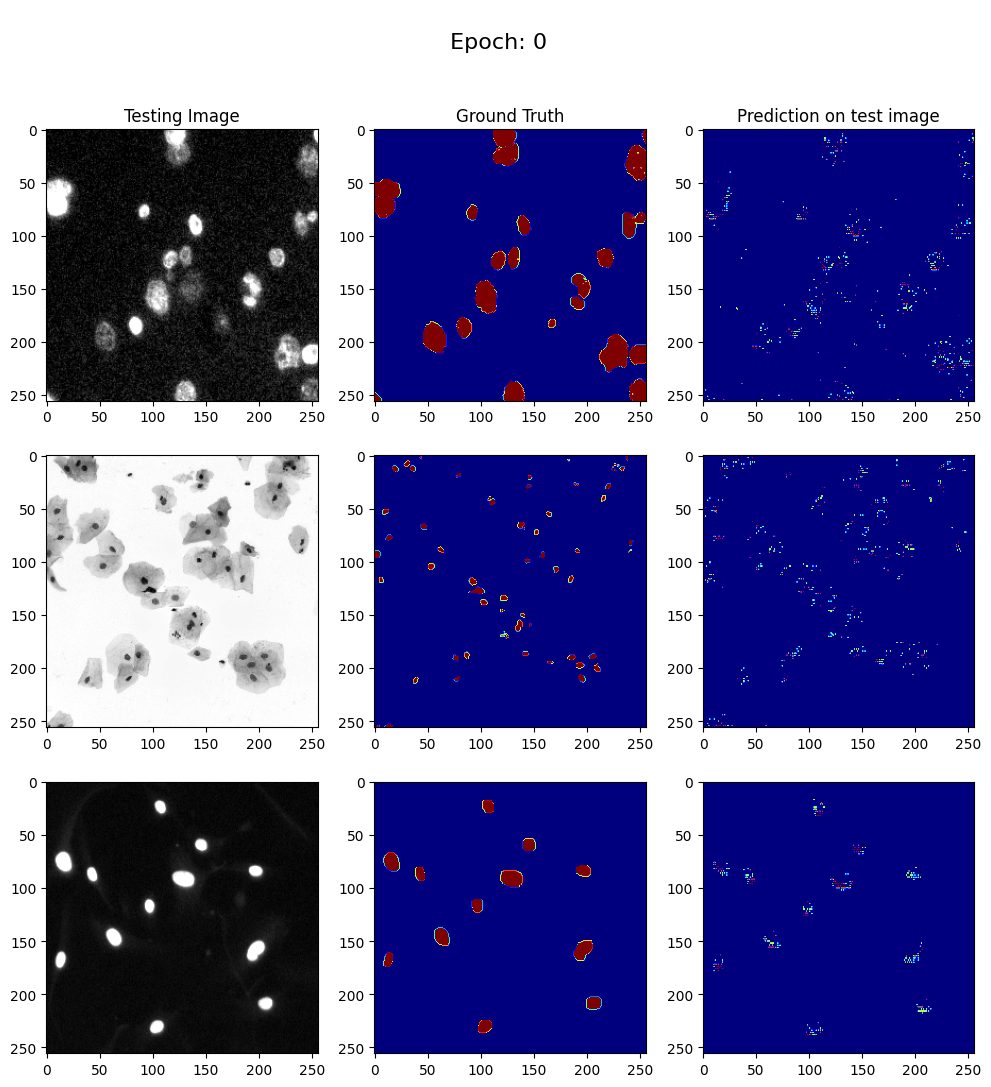


Sample Prediction after epoch 1

4/4 [==============================] - 37s 9s/step - loss: 0.4350 - accuracy: 0.8477 - val_loss: 0.4754 - val_accuracy: 0.8098
Epoch 2/10
1/1 [==============================] - 0s 271ms/step


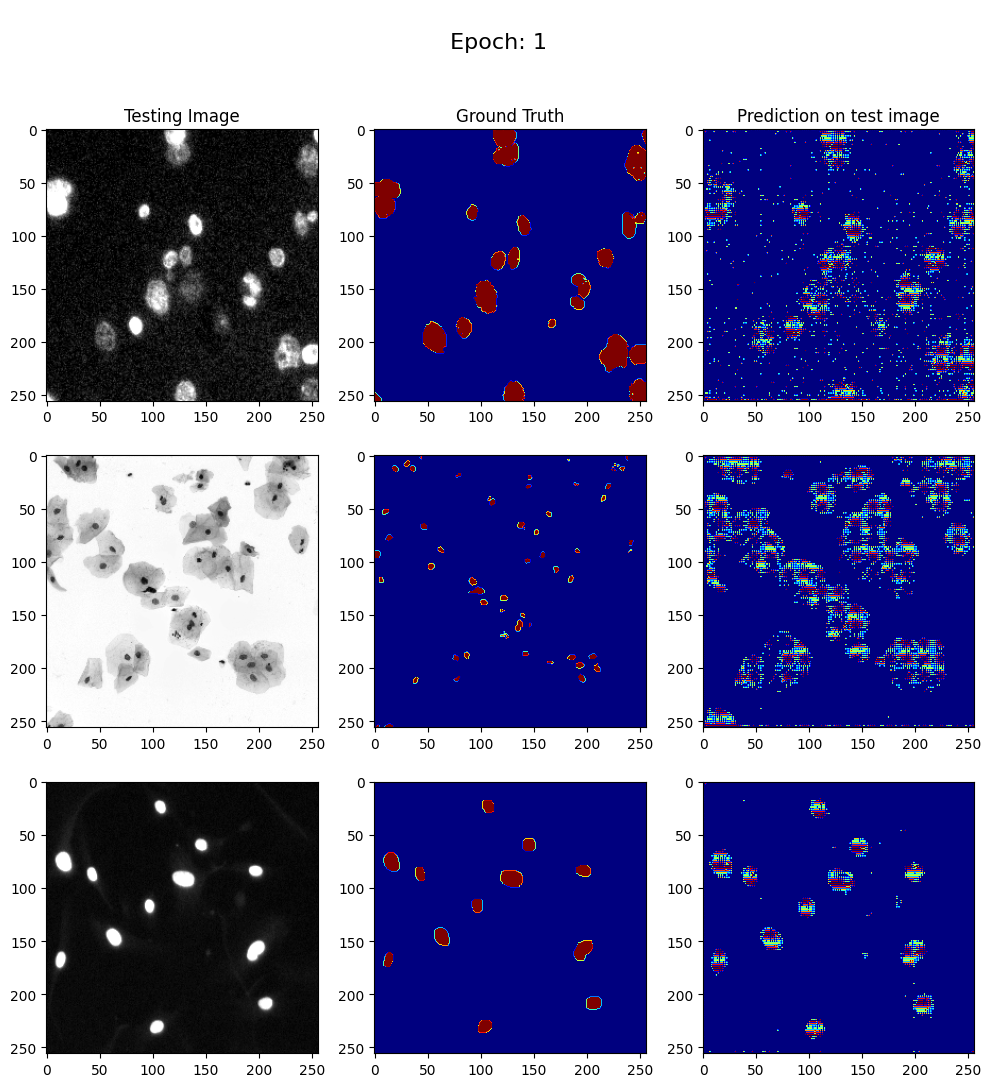


Sample Prediction after epoch 2

4/4 [==============================] - 23s 6s/step - loss: 0.3078 - accuracy: 0.8782 - val_loss: 0.4091 - val_accuracy: 0.8250
Epoch 3/10
1/1 [==============================] - 0s 162ms/step


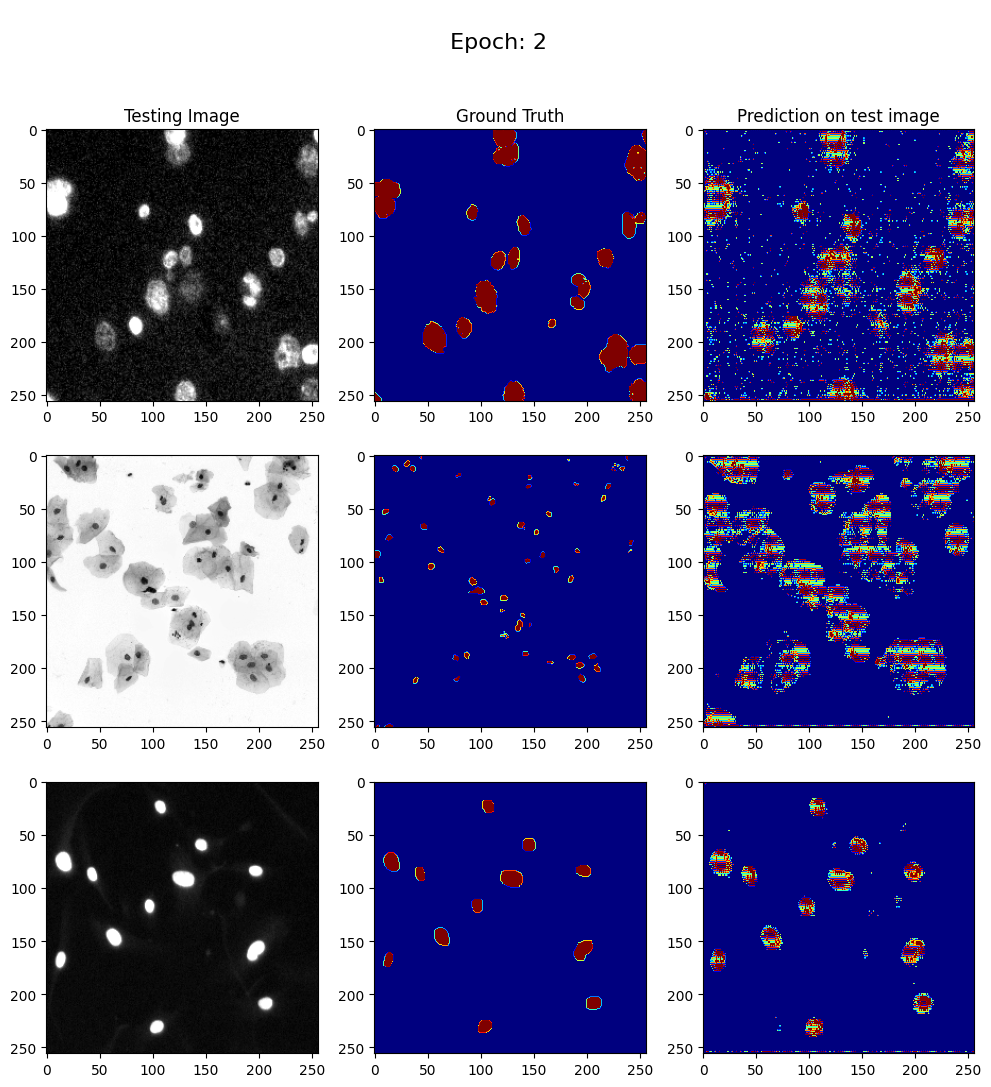


Sample Prediction after epoch 3

4/4 [==============================] - 23s 6s/step - loss: 0.2493 - accuracy: 0.8945 - val_loss: 0.3484 - val_accuracy: 0.8531
Epoch 4/10
1/1 [==============================] - 0s 177ms/step


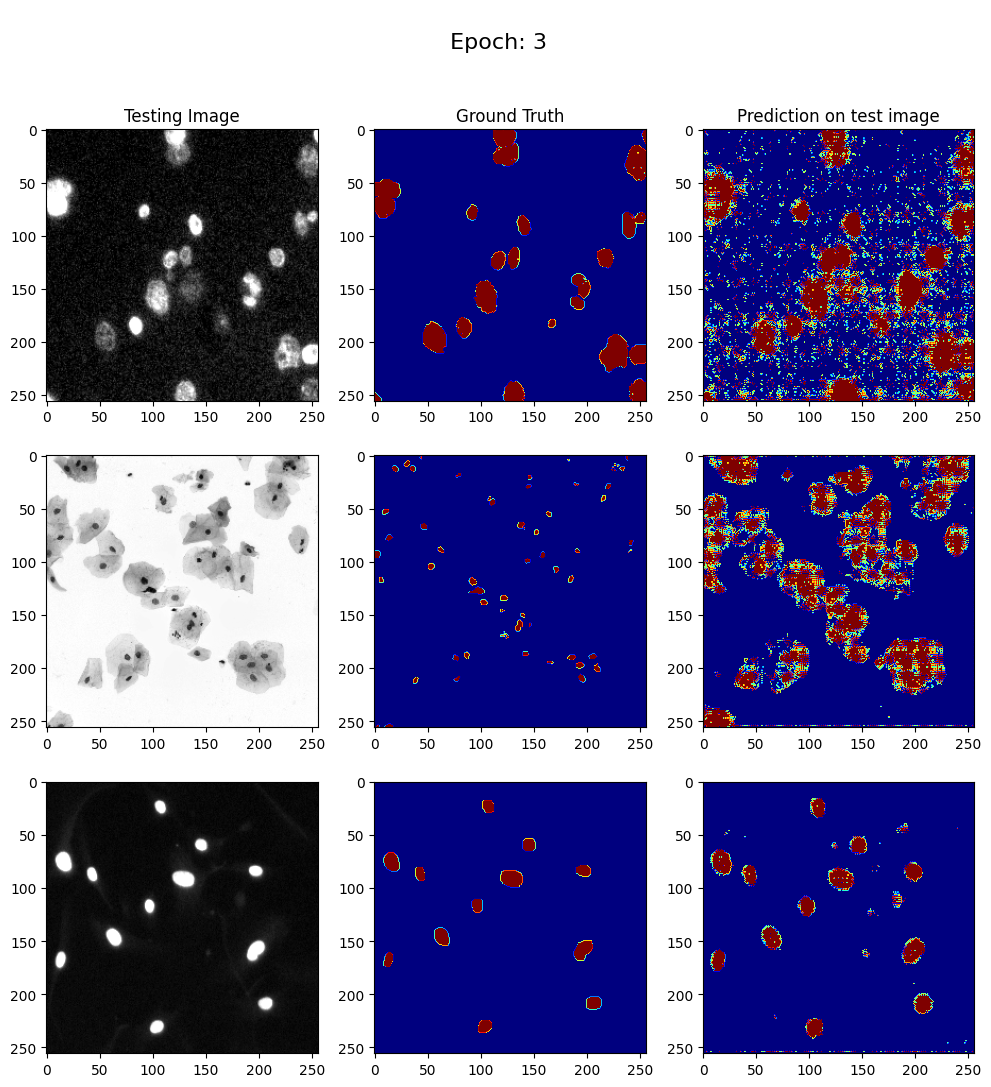


Sample Prediction after epoch 4

4/4 [==============================] - 23s 5s/step - loss: 0.2135 - accuracy: 0.9189 - val_loss: 0.3760 - val_accuracy: 0.8710
Epoch 5/10
1/1 [==============================] - 0s 167ms/step


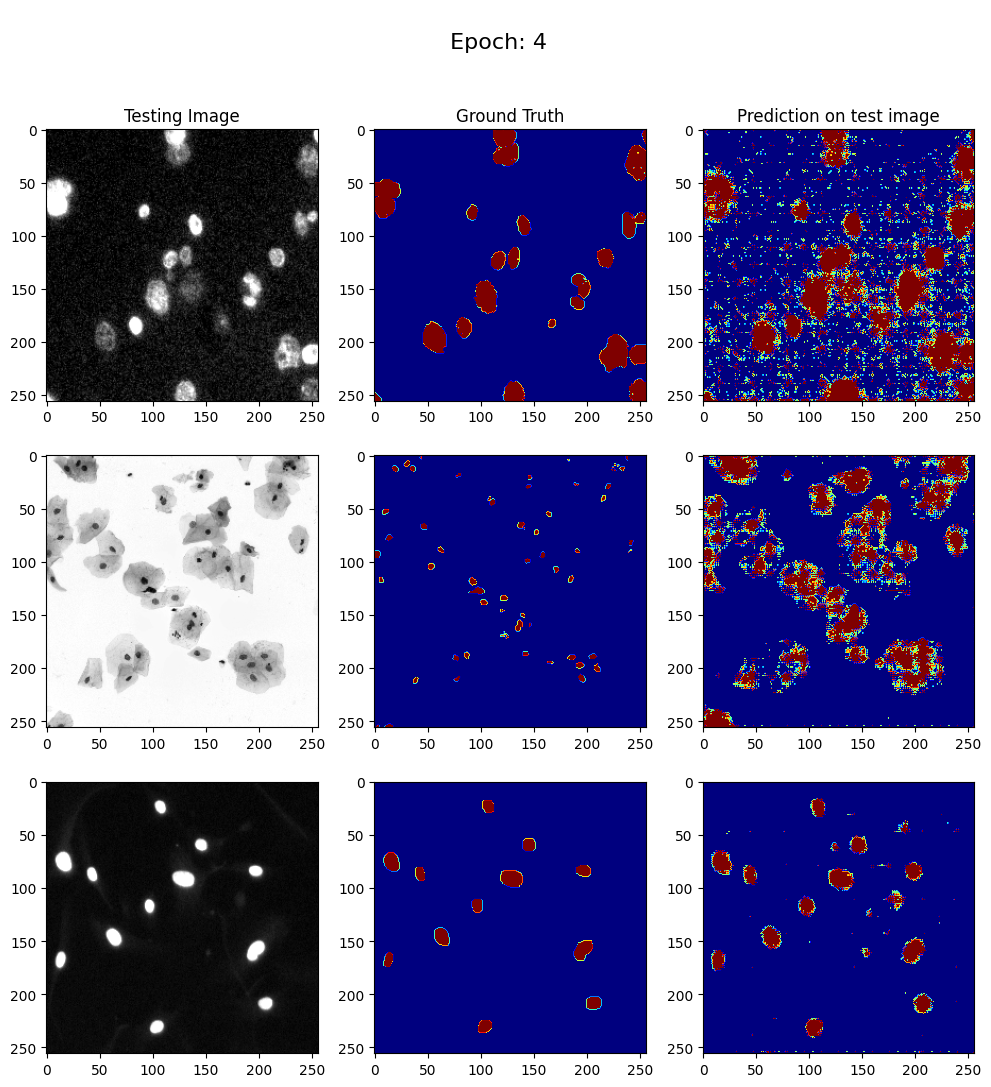


Sample Prediction after epoch 5

4/4 [==============================] - 22s 6s/step - loss: 0.1950 - accuracy: 0.9386 - val_loss: 0.3499 - val_accuracy: 0.8736
Epoch 6/10
1/1 [==============================] - 0s 166ms/step


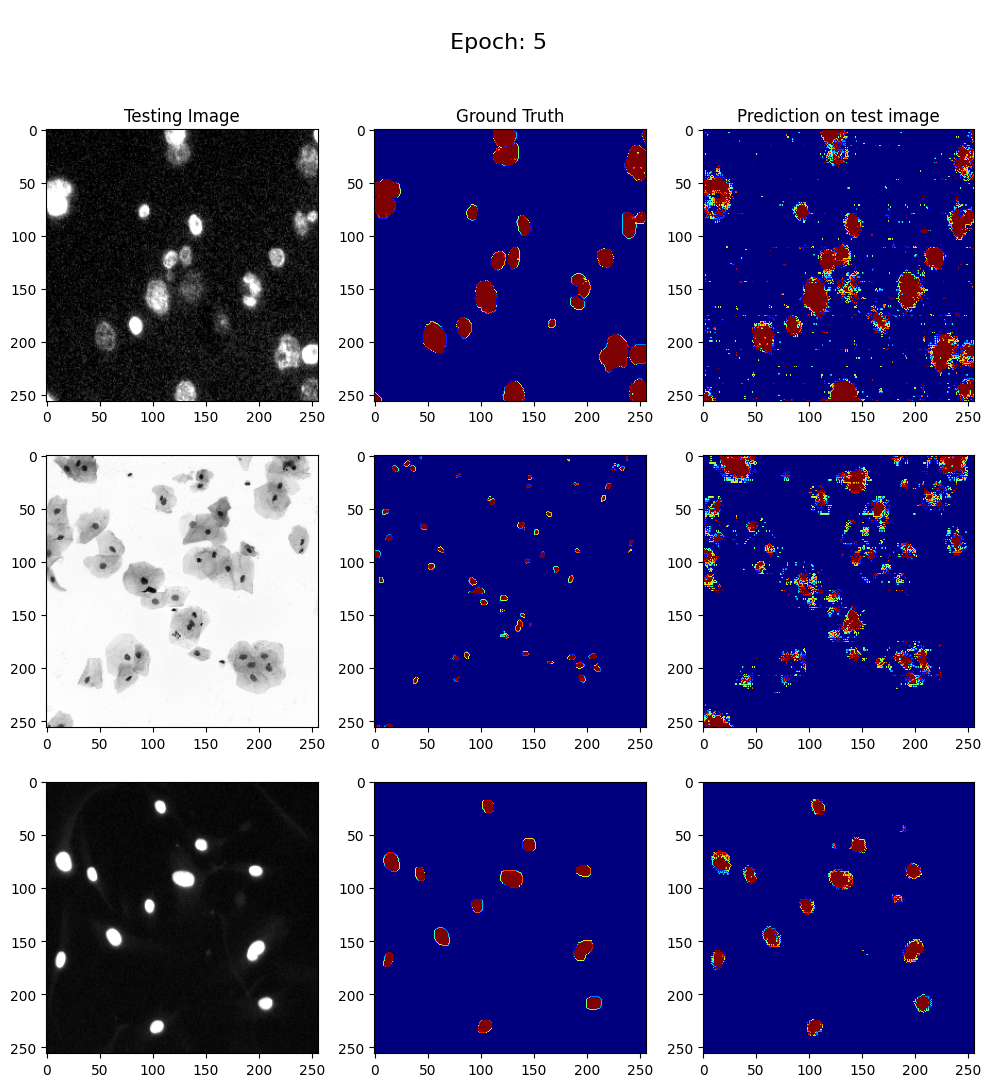


Sample Prediction after epoch 6

4/4 [==============================] - 23s 5s/step - loss: 0.1690 - accuracy: 0.9462 - val_loss: 0.2157 - val_accuracy: 0.9225
Epoch 7/10
1/1 [==============================] - 0s 158ms/step


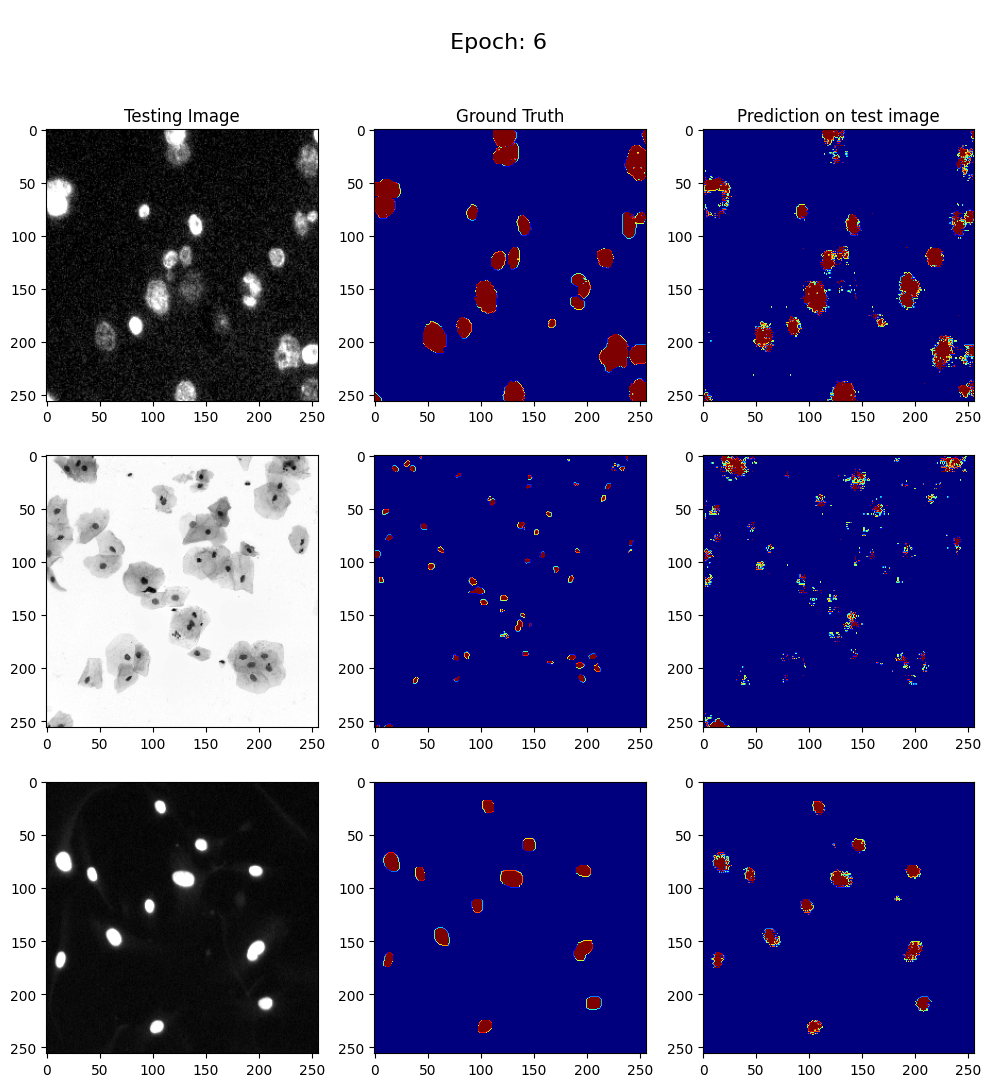

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BATCH_SIZE = 16
VALIDATION_STEPS = len(X_val)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
# sample_image = train_images[0]
# sample_mask = train_masks[0]

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(epoch)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


# Normalize y_train
y_train_normalized = y_train / 255.0

# Assuming your original y_train shape is (256, 256)
# You can expand the dimensions to create (256, 256, 1)
y_train_expanded = np.expand_dims(y_train_normalized, axis=-1)

# Now repeat this single channel along the last axis to create (256, 256, 3)
y_train_rgb = np.repeat(y_train_expanded, 3, axis=-1)


model_history = model.fit(X_train, y_train, epochs=EPOCHS,
                           batch_size = BATCH_SIZE,
                          verbose=1,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=(X_val, y_val),
                          callbacks=[DisplayCallback()]
                          )

In [83]:
X_train[0].shape

(256, 256, 3)

In [84]:
y_train[0].shape

(256, 256)

In [85]:
model.save('./models/cell_seg')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [86]:
model = load_model('./models/cell_seg')

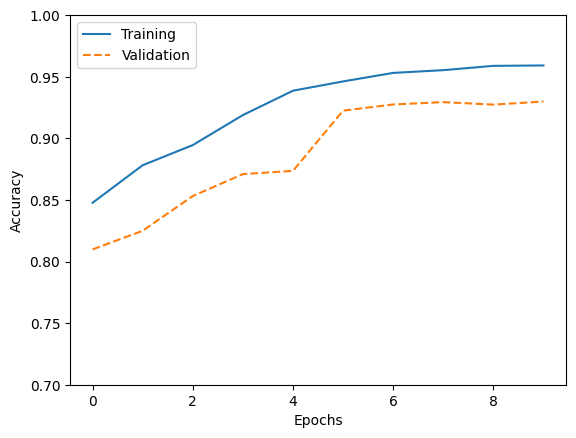

In [87]:
history_1 = model_history.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']



plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

In [88]:
m = tf.keras.metrics.MeanIoU(num_classes=2)

In [89]:
test_img_path = "/content/data/train/images"
test_msk_path = "/content/data/train/masks"


In [90]:
#Capture training image info as a list
test_images_paths = []
test_masks_paths = []

for imgname in os.listdir(images_path):
  test_images_paths.append(os.path.join(test_img_path,imgname))

for imgname in os.listdir(masks_path):
  test_masks_paths.append(os.path.join(test_msk_path,imgname))

In [91]:
test_images_paths.sort()
test_masks_paths.sort()

In [102]:

# Resize images
SIZE_X = 256
SIZE_Y = 256

# Capture training image info as a list
test_images = []
test_masks = []

for imgpath in tqdm.tqdm(test_images_paths):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = preprocessing(img)
    test_images.append(img)

for maskpath in tqdm.tqdm(test_masks_paths):
    mask0 = cv2.imread(maskpath, 0)
    mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
    # Assuming that 'class1' is the class you want to keep and 'bg' is the background class
    mask1[mask1 != classes['nothing']] = classes['nucleon']  # Set all classes except 'class1' to background
    test_masks.append(mask1)

test_images = np.array(test_images)
test_masks = np.array(test_masks)

 64%|██████▎   | 35/55 [00:00<00:00, 332.69it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 1 1]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [

100%|██████████| 55/55 [00:00<00:00, 243.93it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 0 0]]


In [104]:
len(test_images)

55

In [93]:
import keras.backend as K

def dice_coef1(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    #print(tf.reduce_sum(y_true_f).numpy(), tf.reduce_sum(y_pred_f).numpy())
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



In [105]:
# Dice Scores for segmentation
n_classes=2
dfs = {}
# test_images=[]
# test_masks=[]
for i in range(n_classes):
  dfs[i]=[]

for test_img_number in range(len(test_masks_paths)):

  test_img = test_images[test_img_number]
  img_mask = test_masks[test_img_number]

  predicted_img = np.squeeze(create_mask(model.predict(test_images[test_img_number][tf.newaxis, ...])).numpy())

  img_mask_exp = np.zeros((SIZE_X, SIZE_Y, n_classes))
  img_pred_exp = np.zeros((SIZE_X, SIZE_Y, n_classes))
  for i in range(n_classes):
    #print(test_img_number, i)
    img_mask_exp[:,:,i][img_mask==i]=1
    img_pred_exp[:,:,i][predicted_img==i]=1
    df = dice_coef1(img_mask_exp[:,:,i], img_pred_exp[:,:,i]).numpy()
    dfs[i].append(df)

dfss = []
for i in range(n_classes):
  avg = sum(dfs[i]) / len(dfs[i])
  print(f"Dice score of {str(i)}: {str(avg)}")
  dfss.append(avg)

1/1 [==============================] - 0s 159ms/step
Dice score of 0: 0.9740106045816376
Dice score of 1: 0.7902208110074541


In [106]:
predicted_masks = model.predict(test_images, batch_size=1)

55/55 [==============================] - 9s 165ms/step


In [107]:
predicted_masks.shape

(55, 256, 256, 2)

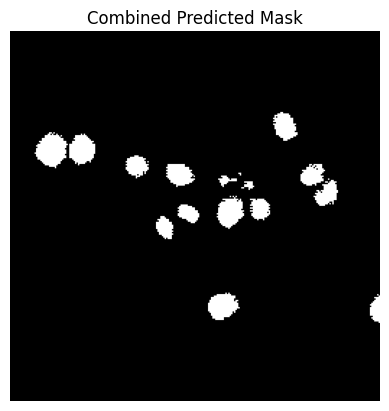

In [109]:
# Assuming predicted_masks is your array with shape (93, 256, 256, 2)
# Combine the channels into a single binary mask (taking the argmax along the last axis)
combined_mask = np.argmax(predicted_masks[0], axis=-1)

# Display the combined mask
plt.imshow(combined_mask, cmap='gray')
plt.title('Combined Predicted Mask')
plt.axis('off')
plt.show()

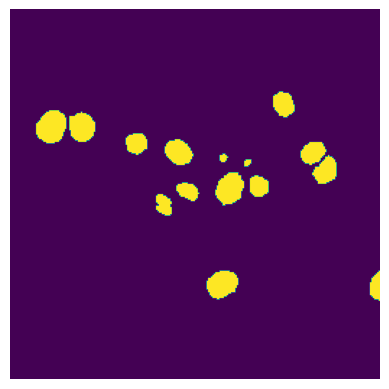

In [110]:
# Display the image
plt.imshow(test_masks[0])
plt.axis('off')  # Turn off axis labels
plt.show()